In [1]:
import mdtraj as md
import pyemma as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Union, Tuple
from pathlib import Path
import pickle
import seaborn as sns
import os
from itertools import product
import string
import pickle

import matplotlib as mpl
from matplotlib import colors

import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral, Ramachandran

from estimate_msm import *
from parameters_CLN import *
#from parameters_BBA import *

In [2]:
hps = pd.read_hdf(summary_path)

# Rename hyperparameters
hps.rename(columns=dict(number='hp_ix', 
                        params_centre='distances__centre', 
                        params_feature='feature__value', 
                        params_n_clusters='cluster__k', 
                        params_scheme='distances__scheme', 
                        params_steepness='distances__steepness', 
                        params_tica_dim='tica__dim', 
                        params_tica_lag='tica__lag', 
                        params_transform='distances__transform'), inplace=True)
hps['tica__stride'] = 1
hps['cluster__stride'] = 1
hps['dihedrals__which'] = 'all'
hps['cluster__max_iter'] = 1000
hps['feature'] = hps.apply(lambda x: f"{x['feature__value']}" if x['feature__value'] =='dihedrals' else f"{x['distances__transform']}-{x['feature__value']}", axis=1)

# Rename features
def f(x):
    for short, long in short_names.items(): 
        x = x.replace(short, long)
    return x
short_names = {'dihedrals': 'dihed.','logistic-distances': 'logit(dist.)', 'linear-distances': 
              'dist.'}
hps['feature'] = hps['feature'].apply(f)

hps.query(f'hp_ix=={hp_ix}')

,hp_ix,value,datetime_start,datetime_complete,duration,distances__centre,feature__value,cluster__k,distances__scheme,distances__steepness,tica__dim,tica__lag,distances__transform,state,tica__stride,cluster__stride,dihedrals__which,cluster__max_iter,feature
52,52,379.427824,2022-12-14 16:14:41.274420,2022-12-14 16:14:41.274420,0 days,NaN,distances,488,ca,NaN,15,71,linear,COMPLETE,1,1,all,1000,dist.


In [3]:
# Output path 
hps.set_index(['hp_ix'], inplace=True)
base_dir = Path(f"{protein}/hp{hp_ix}_{hps.loc[hp_ix,:]['feature']}")
fig_dir = Path.joinpath(base_dir, Path(f"figures"))
fig_dir.mkdir(parents=True, exist_ok=True)
print(base_dir)

CLN/hp52_dist.


In [ ]:
hps.sort_values(by=['value'], ascending=False).head(40)

---
### Compute BS MSM --- Figure 2

In [ ]:
try:
    with open(fig_dir.joinpath(f'{n_bootstraps}_bs'), 'rb') as f:
        data = pickle.load(f)
        ts_samples = data['ts_samples']
        gap_samples = data['gap_samples']
    with open(fig_dir.joinpath('mfpts_summary'), 'rb') as f:
        data = pickle.load(f)
        lags_test = data['lags_test']
        mfpts_fold = data['mfpts_fold']
        mfpts_unfold = data['mfpts_unfold']
        
    # Summarize bootstraps 
    ts_median = np.quantile(ts_samples, 0.5, axis=0)
    ts_ub = np.quantile(ts_samples, 0.95, axis=0)
    ts_lb = np.quantile(ts_samples, 0.05, axis=0)

    gap_median = np.quantile(gap_samples, 0.5, axis=0)
    gap_ub = np.quantile(gap_samples, 0.95, axis=0)
    gap_lb = np.quantile(gap_samples, 0.05, axis=0)
    
    mfpts_fold_mean = np.mean(mfpts_fold, axis=1)
    mfpts_fold_err = np.std(mfpts_fold, axis=1)
    
    mfpts_unfold_mean = np.mean(mfpts_unfold, axis=1)
    mfpts_unfold_err = np.std(mfpts_unfold, axis=1)
    
except:
    print('Compute bootstraps and mfpts first!')

In [ ]:
# Bootstrapped timescales and gaps

ftrajs_all = featurizer(hps.loc[hp_ix,:].to_dict(), traj_paths, top_path)

ts_samples = []
gap_samples = []

for i in range(n_bootstraps):
    ftrajs, ftrajs_ix = bootstrap(ftrajs_all, rng)
    assert len(ftrajs) == len(ftrajs_all)
    
    ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
    dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)
    
    if n_bootstraps>1:
        out_dir = Path.joinpath(base_dir, Path(f'bs_{i}'))
    else:
        out_dir = Path.joinpath(base_dir, Path(f'dtrajs'))
        
    out_dir.mkdir(parents=True, exist_ok=True)
    
    for j in range(len(traj_paths)): 
        traj_path = Path(traj_paths[j]).resolve()
        np.save(file=out_dir.joinpath(traj_path.with_suffix('.npy').name), arr=dtrajs[j])
        
    msm = pm.msm.estimate_markov_model(dtrajs, lag=lag)
    ts = msm.timescales(n_ts)
    
    ts_samples.append(ts[:-1]/1000)
    gap_samples.append(ts[:-1]/ts[1:])
    
ts_samples = np.array(ts_samples)
gap_samples = np.array(gap_samples)

with open(fig_dir.joinpath(f'{n_bootstraps}_bs'), 'wb') as f:
    pickle.dump({'ts_samples':ts_samples, 'gap_samples':gap_samples}, f)

In [ ]:
# Bootstrapped MFPTs

fold_state = 1
unfold_state = 0
mfpts_fold = []
mfpts_unfold = []
repeat = 3

ftrajs = featurizer(hps.loc[hp_ix, :].to_dict(), traj_paths, top_path)
ttrajs_all, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)

for lag_test in lags_test:
    mfpt_fold, mfpt_unfold = [], []
         
    for i in range(repeat):
        ttrajs = bootstrap(ttrajs_all, rng)[0]
        dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)

        msm = pm.msm.estimate_markov_model(dtrajs, lag=lag_test)
        _ = msm.pcca(n_sets)
        ts = msm.timescales(n_ts)

        ix_ls = []
        core_memberships = msm.metastable_memberships.T > core_membership_cutoff
        for i in range(len(core_memberships)):
            ix_ls.append(np.where(core_memberships[i])[0])
        core_sets = np.array(ix_ls)

        mfpt_fold.append(msm.mfpt(core_sets[unfold_state], core_sets[fold_state]))
        mfpt_unfold.append(msm.mfpt(core_sets[fold_state], core_sets[unfold_state]))
        
    mfpts_fold.append(mfpt_fold)
    mfpts_unfold.append(mfpt_unfold)

with open(fig_dir.joinpath('mfpts_summary'), 'wb') as f:
    pickle.dump({'lags_test':lags_test, 'mfpts_fold':mfpts_fold, 'mfpts_unfold': mfpts_unfold}, f)

In [ ]:
if 'hp_ix' in hps.columns: hps.set_index(['hp_ix'], inplace=True)
if hps.loc[hp_ix,:]['feature'] == 'logit(dist.)':
    hp_to_print = hps.loc[hp_ix,:][['feature', 'distances__centre', 'distances__steepness', 'cluster__k', 'tica__dim', 'tica__lag']].to_dict()
    hp_to_print['distances__centre'] = np.round(hp_to_print['distances__centre'], 2)
    hp_to_print['distances__steepness'] = np.round(hp_to_print['distances__steepness'], 2)
else:
    hp_to_print = hps.loc[hp_ix,:][['feature', 'cluster__k', 'tica__dim', 'tica__lag']].to_dict()
str_to_print = str(hp_to_print).replace(',','\n\n').replace("'",'').replace("{",' ').replace("}",'')

In [ ]:
# Figure 2 : HP table + TS + TS gap

with sns.plotting_context('paper', font_scale=2):
    fig = plt.figure(figsize=(19, 6), constrained_layout=True)
    gs = fig.add_gridspec(nrows=6, ncols=19)
    
    # Hyperparameter values
    ax1 = fig.add_subplot(gs[:, :3])
    ax1.text(0.05, 0.95, str_to_print, transform=ax1.transAxes, verticalalignment='top')
    ax1.axis('off')
    
    
    # Timescales
    ax2 = fig.add_subplot(gs[:3, 3:13])
    x = np.arange(n_ts-1)+2
    y = ts_median
    yerr = (ts_median-ts_lb, ts_ub-ts_median)
    ax2.errorbar(x, y, yerr, elinewidth=2, lw=2, marker='o', markersize=6, ecolor='r', c='k')
    
    ax2.set_yscale('log')
    ax2.set_ylabel(r"Timescales ($\mu$s)")
    ax2.tick_params(bottom=True, top=False, left=True, right=False)
    ax2.annotate(text='(a)', xy=(0.94, 0.94), xycoords='axes fraction', ha='left', va='top')
    ax2.grid(visible=True, axis='y')
    ax2.set_ylim([0.01, max(ts_ub)*3])
    
    
    # Gaps
    ax3 = fig.add_subplot(gs[3:, 3:13])
    y = gap_median
    yerr = (gap_median-gap_lb, gap_ub-gap_median)
    ax3.errorbar(x, y, yerr, elinewidth=2, lw=2, marker='o', markersize=6, ecolor='r', c='k')
    
    ax3.set_yscale('log')
    ax3.set_ylabel("Gap")
    ax3.set_xlabel('Process')
    ax3.tick_params(bottom=True, top=False, left=True, right=False)
    ax3.annotate(text='(b)', xy=(0.94, 0.94), xycoords='axes fraction', ha='left', va='top')
    ax3.grid(visible=True, axis='y')
    ax3.set_ylim([0.5, max(gap_ub)*3])
    
    
    # MFPTs vs lags
    ax4 = fig.add_subplot(gs[0:, 13:])
    x = lags_test
    
    y1, y1e = np.divide(mfpts_fold_mean, 1000), np.divide(mfpts_fold_err, 1000)
    y2, y2e = np.divide(mfpts_unfold_mean, 1000), np.divide(mfpts_unfold_err, 1000)
    
    xlim = [min(x)*0.5, max(x)*2]
    ylim = [min(y1)*0.5, max(y2)*2]    
    x_fill = np.arange(ylim[0]*1000, xlim[1],1)
    
    ax4.errorbar(x, y1, y1e, marker='o', lw=2, markersize=6, c='k', label='Folding')
    ax4.errorbar(x, y2, y2e, marker='o', lw=2, markersize=6, c='r', label='Unfolding')    
    ax4.fill_between(x_fill, x_fill/1000, alpha=0.5, color='grey')
    
    ax4.tick_params(which='both', axis='both', bottom=True, top=False, left=True, right=False)
    ax4.set_ylabel("MFPT ($\mu$s)")
    ax4.set_xlabel("Lag time (ns)")
    ax4.set_xlim(xlim)
    ax4.set_ylim(ylim)
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.legend(loc='upper left')
    ax4.annotate(text='(c)', xy=(0.97, 0.97), xycoords='axes fraction', ha='right', va='top')
    
    plt.savefig(fig_dir.joinpath(f'SI1_model_{hp_ix}.pdf'), dpi=600)
    plt.show()

---
### Validate single MSM --- Figure 1

In [ ]:
# Validate a single trial
# Estimate MSM and perform PCCA+

ftrajs = featurizer(hps.loc[hp_ix,:].to_dict(), traj_paths, top_path)

ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)

out_dir = Path.joinpath(base_dir, Path(f'dtrajs'))
out_dir.mkdir(parents=True, exist_ok=True)

for j in range(len(traj_paths)): 
    traj_path = Path(traj_paths[j]).resolve()
    np.save(file=out_dir.joinpath(traj_path.with_suffix('.npy').name), arr=dtrajs[j])
    
msm = pm.msm.estimate_markov_model(dtrajs, lag=lag)
_ = msm.pcca(n_sets)
ts = msm.timescales(n_ts)

In [ ]:
# Compute metastable set population

print('\nstate\tπ\t\tG/kT\t\tNo.')
population = []
number = []
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    population.append(p)
    number.append(s.shape[0]) 
    print('{}\t{:f}\t{:f}\t{}'.format(i, p, -np.log(p), s.shape[0]))

In [ ]:
# Compute core set 

ix_ls = []
core_memberships = msm.metastable_memberships.T > core_membership_cutoff
for i in range(len(core_memberships)):
    ix_ls.append(np.where(core_memberships[i])[0])
core_sets = np.array(ix_ls)

# Compute MFPT between core sets

mfpt = np.zeros((n_sets, n_sets))
for i, j in product(range(n_sets), repeat=2):
    mfpt[i, j] = msm.mfpt(core_sets[i], core_sets[j])

mfpt_df = pd.DataFrame(np.round(mfpt, decimals=2), index=range(1, n_sets + 1), columns=range(1, n_sets + 1))
print(mfpt_df, '\n(ns)')

In [ ]:
# Map reference conformation

ftraj_test = featurizer(hps.loc[hp_ix, :].to_dict(), ref_path, top_path)
ftraj_test_tica = tica_mod.transform(ftraj_test)[0]
microstate_test = kmeans_mod.assign(ftraj_test_tica)
metastate_test = msm.metastable_assignments[microstate_test]
#test_dict = {label:[test_traj_path[i], microstate[i][0], metastate[i][0]] for i, label in enumerate(test_labels)}

In [ ]:
mem = msm.metastable_memberships.transpose()

# Microstate positions
x = kmeans_mod.clustercenters[:, 0]
y = kmeans_mod.clustercenters[:, 1]  

# Concatenate featurised trajectories
Y = np.concatenate(ttrajs)

# Find cluster center
dists = msm.metastable_distributions.copy()
dists[msm.metastable_memberships.T<core_membership_cutoff] = 0
dists = dists/np.sum(dists, axis=1)[:, np.newaxis]
max_dists = dists.copy()
mask = max_dists==np.tile(np.max(max_dists, axis=1)[:, np.newaxis], (max_dists.shape[1]))
max_ix = np.where(mask)[1]

In [ ]:
ttraj_cat = np.concatenate(ttrajs)
dtrajs_cat = np.concatenate(dtrajs)

ms_1 = core_memberships[0][dtrajs_cat].astype(int)*-1
ms_2 = core_memberships[1][dtrajs_cat].astype(int)*1
core_ms = ms_1 + ms_2
core_ms = (core_ms + 1)/2

In [ ]:
c_centers = kmeans_mod.clustercenters

egv = msm.eigenvectors_right()
egv_max = msm.eigenvectors_right()[:, 1].argmax()
egv_min = msm.eigenvectors_right()[:, 1].argmin()

divnorm = colors.TwoSlopeNorm(vmin=min(egv[:,1]), vcenter=0, vmax=max(egv[:,1]))
annotation_loc = {'xy':(0.98, 0.01), 'xycoords':'axes fraction', 'ha':'right', 'va':'bottom'}

from matplotlib.ticker import FormatStrFormatter

with sns.plotting_context('paper', font_scale=1.8):
    fig, axes = plt.subplots(1, 5, figsize=(25,6), sharey=True)
    axes[2].axis('off')
    axes[4].axis('off')
    
    # Free energy surface
    fes = pm.plots.plot_free_energy(ttraj_cat[:, 0], 
                                    ttraj_cat[:, 1],
                                    weights=np.concatenate(msm.trajectory_weights()),
                                    cbar=False,
                                    nbins=80,
                                    cmap='jet',
                                    ax=axes[0])
    axes[0].set_xlabel('IC1')
    axes[0].set_ylabel('IC2')
    axes[0].annotate(text=f'(a)', xy=(0.03, 0.95), xycoords='axes fraction', ha='left', va='top')
    
    cbar = fig.colorbar(fes[2]['mappable'], location='top', ticks=np.arange(0,9,2), 
                 label=r'Free energy ($k_\mathrm{B}T$)', format='%.1f')

    #cbar.ax.set_xlabel(r'Free energy ($k_\mathrm{B}T$)', fontsize=15)

    
    # Macrostates
    ms = pm.plots.plot_contour(ttraj_cat[:, 0], 
                               ttraj_cat[:, 1],
                               core_ms,
                               ncontours=2,
                               nbins=80,
                               ax=axes[1],
                               cmap='coolwarm',
                               cbar=False,
                               mask=True)
    axes[1].scatter(c_centers[:,0], c_centers[:,1], s=5, c='k', alpha=0.8)
    axes[1].set_xlabel('IC1')
    axes[1].scatter(x=c_centers[:,0][microstate_test[0]],y=c_centers[:,1][microstate_test[0]],
                       color='tomato', marker='*', s=300, label=test_labels)
    #axes[0][1].annotate(text=f"S1 population: {core_population[0]:.2f}\nS2 population: {core_population[1]:.2f}", **annotation_loc)

    axes[1].legend(loc='upper right')
    cbar = fig.colorbar(ms[2]['mappable'], location='top', ticks=[0.2, 0.6, 1], label='PCCA+')
    cbar.ax.set_xticklabels(['S1','intermediate','S2'])
    axes[1].annotate(text=f'(b)', xy=(0.03, 0.95), xycoords='axes fraction', ha='left', va='top')
    
    
    # Eigenvector
    eg = pm.plots.plot_contour(ttraj_cat[:, 0], 
                                ttraj_cat[:, 1],
                                egv[dtrajs_cat, 1],
                                cmap='coolwarm',
                                norm=divnorm,
                                cbar=False,
                                mask=True,
                                ax=axes[3])
    axes[3].scatter(x=c_centers[:,0][egv_max], y=c_centers[:,1][egv_max], c='k', 
               marker='X', s=120, alpha=1, label='max')
    axes[3].scatter(x=c_centers[:,0][egv_min], y=c_centers[:,1][egv_min], c='k', 
               marker='v', s=120, alpha=1, label='min')
    axes[3].legend()
    axes[3].set_xlabel('IC1')
    cbar = fig.colorbar(eg[2]['mappable'], location='top', label=r'$2^{nd}$ right eigenvector', 
                 ticks=np.linspace(min(egv[:,1]), max(egv[:,1]), 5), format='%.1f')
    axes[3].annotate(text=f'(c)', xy=(0.03, 0.95), xycoords='axes fraction', ha='left', va='top')

    for ax in axes.flatten():
        ax.tick_params(axis='both', bottom=True, top=False, left=True, right=False)
        ax.set_xlim([-2, 1.5])
        ax.set_ylim([-6.8, 2.4])
        
    plt.savefig(fig_dir.joinpath(f'SI2_model_{hp_ix}.png'), dpi=600)
    plt.tight_layout()
    plt.show()

*** 
### Validate single MSM -- Figure 3

In [4]:
# Estimate bayesian MSM and perform PCCA+

ftrajs = featurizer(hps.loc[hp_ix,:].to_dict(), traj_paths, top_path)

ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)

/home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%| 

getting output of TICA:   0%|

/home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers: 

kmeans iterations:   0%| | 0/

getting output of KmeansClust

In [5]:
its = pm.msm.its(np.concatenate(dtrajs), nits=3, lags=[1, 5, 10, 20, 50, 100], errors='bayes')

estimating BayesianMSM:   0%|

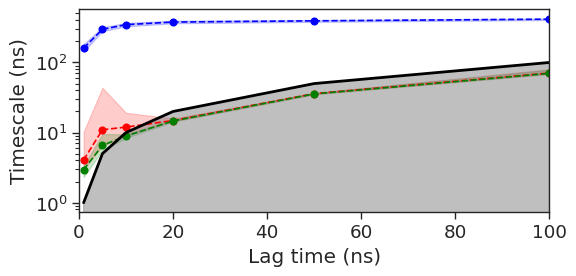

In [6]:
with sns.plotting_context('paper', font_scale=1.5):
    fig, ax = plt.subplots(figsize=(6,3))
    ax = pm.plots.plot_implied_timescales(its, units='ns', dt=1, show_mle=False)
    ax.tick_params(which='both', axis='both', bottom=True, top=False, left=True, right=False)
    ax.set_ylabel('Timescale (ns)')
    ax.set_xlabel('Lag time (ns)')
    ax.set_xlim([0, 100])
    
    plt.tight_layout()
    plt.savefig(fig_dir.joinpath(f'its_model_{hp_ix}.pdf'), dpi=600)
    plt.show()

---
### Sample egv2 extreme states

In [ ]:
is_single_core = True
ref = md.load(ref_path)
state_out_dir = base_dir.joinpath(f'state_is_single_{is_single_core}')
state_out_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
samples = {}
for i in range(2):
    egv_max = msm.eigenvectors_right()[:, i+1].argmax()
    egv_min = msm.eigenvectors_right()[:, i+1].argmin()
    egv_zero = abs(msm.eigenvectors_right()[:, i+1]).argmin()
    samples[f'egv{i+2}_max_{egv_max}'] = msm.sample_by_state(20, [egv_max])
    samples[f'egv{i+2}_min_{egv_min}'] = msm.sample_by_state(20, [egv_min])
    samples[f'egv{i+2}_zero_{egv_zero}'] = msm.sample_by_state(20, [egv_zero])

In [ ]:
rmsds = []
states = []

with open(state_out_dir.joinpath('out.txt'), 'w') as f: 
    f.writelines(f'Protein {protein}; hp_id {hp_ix}\n')
    
    for n, sample in samples.items():
        outfile = str(state_out_dir.joinpath(f'{n}.pdb'))

        traj = pm.coordinates.save_traj(traj_paths, sample, outfile=None, top=top_path)
        traj.superpose(reference=ref)
        states.append(traj)
        traj.save_pdb(str(outfile))
        
        if protein == 'CLN': 
            process_pdb_file(str(outfile), str(state_out_dir.joinpath(f'{n}_fixed.pdb')))
        
        # Compute rg
        rg = md.compute_rg(traj)
        ave_rg, std_rg = np.mean(rg), np.std(rg)

        # Compute rmsd (angstrom) within samples
        rmsd_list = []
        for i in range(len(traj)):
            rmsd_list.append(md.rmsd(traj, traj[i]))
        rmsd_array = np.array(rmsd_list)*10
        ave_rmsd, std_rmsd = np.mean(rmsd_array), np.std(rmsd_array)
        
        rmsd = md.rmsd(target=traj, reference=ref)*10
        ave_ref_rmsd, std_ref_rmsd = np.mean(rmsd), np.std(rmsd)
        rmsds.append(rmsd)
        
        f.writelines(f'{n}\naverage_rg {ave_rg:.2f}, std_rg {std_rg:.2f}\naverage_rmsd {ave_rmsd:.2f}, std_rmsd {std_rmsd:.2f}\nave_ref_rmsd {ave_ref_rmsd:.2f}, std_ref_rmsd {std_ref_rmsd:.2f}\n\n')
    
rmsds_df = pd.DataFrame({f"state_{i}": np.round(rmsd,2) for i, rmsd in enumerate(rmsds)}).melt()

In [ ]:
def process_pdb_file(input_file_path, output_file_path):
    new_file_content = []
    conformation_lines = []
    
    with open(input_file_path,'r') as file:
        lines = file.readlines()
        
    for line in lines:
        if line.startswith("ATOM") or line.startswith("TER"):
            conformation_lines.append(line)
        elif line.startswith("ENDMDL"):
            new_conformation = fix_conformation(conformation_lines)
            new_file_content.extend(new_conformation)
            new_file_content.append(line)
            conformation_lines = []
        else:
            new_file_content.append(line)
            
    with open(output_file_path, "w") as file:
        file.writelines(new_file_content)    
            
def fix_conformation(lines):
    atom_lines = [line for line in lines if line.startswith('ATOM')]
    other_lines = [line for line in lines if not line.startswith('ATOM')]
    
    atom_145 = atom_lines[144]
    fixed_atom_145 = atom_145[:13] + 'C' + atom_145[14:-3] + 'C' + atom_145[-2:]
    
    atom_lines[144] = atom_lines[144].replace('N','C')
    atom_lines[147] = atom_lines[147].replace('C','N')
    
    atom_145 = atom_lines[144]  # 0-indexed
    atom_146 = atom_lines[145]  # 0-indexed
    atom_147 = atom_lines[146]
    
    # Remove atoms 146 and 147
    del atom_lines[144:147]

    # Append atoms 146 and 147 to the end
    atom_lines.append(atom_145)
    atom_lines.append(atom_146)
    atom_lines.append(atom_147)
    
    # Adjust the indices
    for i, line in enumerate(atom_lines):
        new_line = line[:6] + f"{i+1:5d}" + line[11:]
        atom_lines[i] = new_line
    
    return atom_lines + other_lines